## yfactor_sisv_sweep_necstdb.py 用可視化ツールの template です。
- 概要：
  - 全 cell を実行すると、20 IF の hot / cold の SIS vsweep 時の y-factor が表示されます
- 特筆事項：
  - 20 IF 分のデータが存在しなくても、存在する IF データのみで plot 可能です
-  <font color="red">notebook 上で plot を行いたい場合：　</font>
  - 「モジュールを import します。」 の cell で%matplotlib inline のコメントアウトを外してください

### モジュールを import します。

In [2]:
import os
import sys
import time
import numpy as np
import pandas
import pandas as pd
import matplotlib
matplotlib.use('Agg')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.facecolor'] = 'white'
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
if sys.argv[1] == 'xxx': pass
else: 
    %matplotlib inline

import necstdb

### database を読み込みます。

In [10]:
cwd = os.getcwd()
mode, date = cwd.split('/')[-2], cwd.split('/')[-1]

date = '20190831_031800'

data_path_hot = '/home/amigos/data/rx/{mode}/hot/{date}.necstdb_/'.format(**locals())
data_path_cold = '/home/amigos/data/rx/{mode}/cold/{date}.necstdb_/'.format(**locals())

# data_path = [
#     '/mnt/media/usbdisk/data/rx/{mode}/hot/{date}'.format(**locals()),
#     '/mnt/media/usbdisk/data/rx/{mode}/cold/{date}'.format(**locals())
# ]

db_hot = necstdb.opendb(data_path_hot)
db_cold = necstdb.opendb(data_path_cold)

### IF ごとに、パラメーターをディクショナリに格納します。

In [11]:
IF_list = [
    '2l_usb', '2l_lsb', '2r_usb', '2r_lsb',
    '3l_usb', '3l_lsb', '3r_usb', '3r_lsb',
    '4l_usb', '4l_lsb', '4r_usb', '4r_lsb',
    '5l_usb', '5l_lsb', '5r_usb', '5r_lsb',
    '1lu', '1ll', '1ru', '1rl'
]
beam_list = [
    '2l', '2r', '3l', '3r',
    '4l', '4r', '5l', '5r', 
    '1lu', '1ll', '1ru', '1rl'
]
vol_topic_list = ['sis_vol_{}'.format(vol) for vol in beam_list]
cur_topic_list = ['sis_cur_{}'.format(cur) for cur in beam_list]
IF_topic_list = ['if_{}'.format(IF) for IF in IF_list]

In [16]:
cwd = os.getcwd()
mode, date = cwd.split('/')[-2], cwd.split('/')[-1]

date = '20190831_031800'

data_path_hot = '/home/amigos/data/rx/{mode}/hot/{date}.necstdb_/'.format(**locals())
data_path_cold = '/home/amigos/data/rx/{mode}/cold/{date}.necstdb_/'.format(**locals())

# data_path = [
#     '/mnt/media/usbdisk/data/rx/{mode}/hot/{date}'.format(**locals()),
#     '/mnt/media/usbdisk/data/rx/{mode}/cold/{date}'.format(**locals())
# ]

db_hot = necstdb.opendb(data_path_hot)
db_cold = necstdb.opendb(data_path_cold)

In [98]:
vol_df_hot, cur_df_hot, IF_df_hot, vol_df_cold, cur_df_cold, IF_df_cold = {}, {}, {}, {}, {}, {}
for vol_topic, cur_topic in zip(vol_topic_list, cur_topic_list):
    vol_df_hot[vol_topic] = db_hot.open_table(vol_topic).read(astype='pandas')
    vol_df_hot[vol_topic]['timestamp'] = pd.to_datetime(vol_df_hot[vol_topic]['timestamp'], unit='s')
    vol_df_hot[vol_topic] = vol_df_hot[vol_topic].set_index('timestamp').sort_index()    
    cur_df_hot[cur_topic] = db_hot.open_table(cur_topic).read(astype='pandas')
    cur_df_hot[cur_topic]['timestamp'] = pd.to_datetime(cur_df_hot[cur_topic]['timestamp'], unit='s')
    cur_df_hot[cur_topic] = cur_df_hot[cur_topic].set_index('timestamp').sort_index() 
    vol_df_cold[vol_topic] = db_cold.open_table(vol_topic).read(astype='pandas')
    vol_df_cold[vol_topic]['timestamp'] = pd.to_datetime(vol_df_cold[vol_topic]['timestamp'], unit='s')
    vol_df_cold[vol_topic] = vol_df_cold[vol_topic].set_index('timestamp').sort_index() 
    cur_df_cold[cur_topic] = db_cold.open_table(cur_topic).read(astype='pandas')
    cur_df_cold[cur_topic]['timestamp'] = pd.to_datetime(cur_df_cold[cur_topic]['timestamp'], unit='s')
    cur_df_cold[cur_topic] = cur_df_cold[cur_topic].set_index('timestamp').sort_index()         
for IF_topic in IF_topic_list:
    try:
        IF_df_hot[IF_topic] = db_hot.open_table(IF_topic).read(astype='pandas')
        IF_df_hot[IF_topic]['timestamp'] = pd.to_datetime(IF_df_hot[IF_topic]['timestamp'], unit='s')
        IF_df_hot[IF_topic] = IF_df_hot[IF_topic].set_index('timestamp').sort_index()
        IF_df_cold[IF_topic] = db_cold.open_table(IF_topic).read(astype='pandas')
        IF_df_cold[IF_topic]['timestamp'] = pd.to_datetime(IF_df_cold[IF_topic]['timestamp'], unit='s')
        IF_df_cold[IF_topic] = IF_df_cold[IF_topic].set_index('timestamp').sort_index()
    except: pass

In [122]:
dataset = {}
resample_time = '0.04S'
for IF in IF_list:
    if IF in IF_list[:16]:
        if '_usb' in IF: beam = IF.replace('_usb', '')
        elif '_lsb' in IF: beam = IF.replace('_lsb', '')
    elif IF in IF_list[16:]: beam = IF
    try:
        print('[info] : {} data ( power, vol, cur) is loaded.'.format(IF))
        dataset[IF]  = pd.concat(
            [
                pd.concat(
                    [
                        vol_df_hot['sis_vol_{}'.format(beam)].rename(columns={'data': 'sis_vol_{}'.format(IF)}) \
                        .astype(float).resample(resample_time).mean().round({'sis_vol_{}'.format(IF): 2}),
                        cur_df_hot['sis_cur_{}'.format(beam)].rename(columns={'data': 'sis_cur_{}_hot'.format(IF)}) \
                        .astype(float).resample(resample_time).mean(),
                        IF_df_hot['if_{}'.format(IF)].rename(columns={'data': 'if_{}_hot'.format(IF)}) \
                        .astype(float).resample(resample_time).mean(),    
                    ],
                    axis=1
                    ).set_index('sis_vol_{}'.format(IF)).groupby(level=0).mean(),

                pd.concat(
                    [
                        vol_df_cold['sis_vol_{}'.format(beam)].rename(columns={'data': 'sis_vol_{}'.format(IF)}) \
                        .astype(float).resample(resample_time).mean().round({'sis_vol_{}'.format(IF): 2}),
                        cur_df_cold['sis_cur_{}'.format(beam)].rename(columns={'data': 'sis_cur_{}_cold'.format(IF)}) \
                        .astype(float).resample(resample_time).mean(),
                        IF_df_cold['if_{}'.format(IF)].rename(columns={'data': 'if_{}_cold'.format(IF)}) \
                        .astype(float).resample(resample_time).mean(),
                    ],
                    axis=1
                    ).set_index('sis_vol_{}'.format(IF)).groupby(level=0).mean(),
                ],
                axis=1
        )
    except: 
        print('[alart] : {} data is not exist.'.format(IF))
        dataset[IF] = ''

[info] : 2l_usb data ( power, vol, cur) is loaded.
[info] : 2l_lsb data ( power, vol, cur) is loaded.
[info] : 2r_usb data ( power, vol, cur) is loaded.
[info] : 2r_lsb data ( power, vol, cur) is loaded.
[info] : 3l_usb data ( power, vol, cur) is loaded.
[info] : 3l_lsb data ( power, vol, cur) is loaded.
[info] : 3r_usb data ( power, vol, cur) is loaded.
[info] : 3r_lsb data ( power, vol, cur) is loaded.
[info] : 4l_usb data ( power, vol, cur) is loaded.
[alart] : 4l_usb data is not exist.
[info] : 4l_lsb data ( power, vol, cur) is loaded.
[info] : 4r_usb data ( power, vol, cur) is loaded.
[info] : 4r_lsb data ( power, vol, cur) is loaded.
[info] : 5l_usb data ( power, vol, cur) is loaded.
[info] : 5l_lsb data ( power, vol, cur) is loaded.
[info] : 5r_usb data ( power, vol, cur) is loaded.
[info] : 5r_lsb data ( power, vol, cur) is loaded.
[info] : 1lu data ( power, vol, cur) is loaded.
[info] : 1ll data ( power, vol, cur) is loaded.
[info] : 1ru data ( power, vol, cur) is loaded.
[inf

### hot と cold のパワーと、iv を plot します。

info : Saved image. ( hot_cold.png )


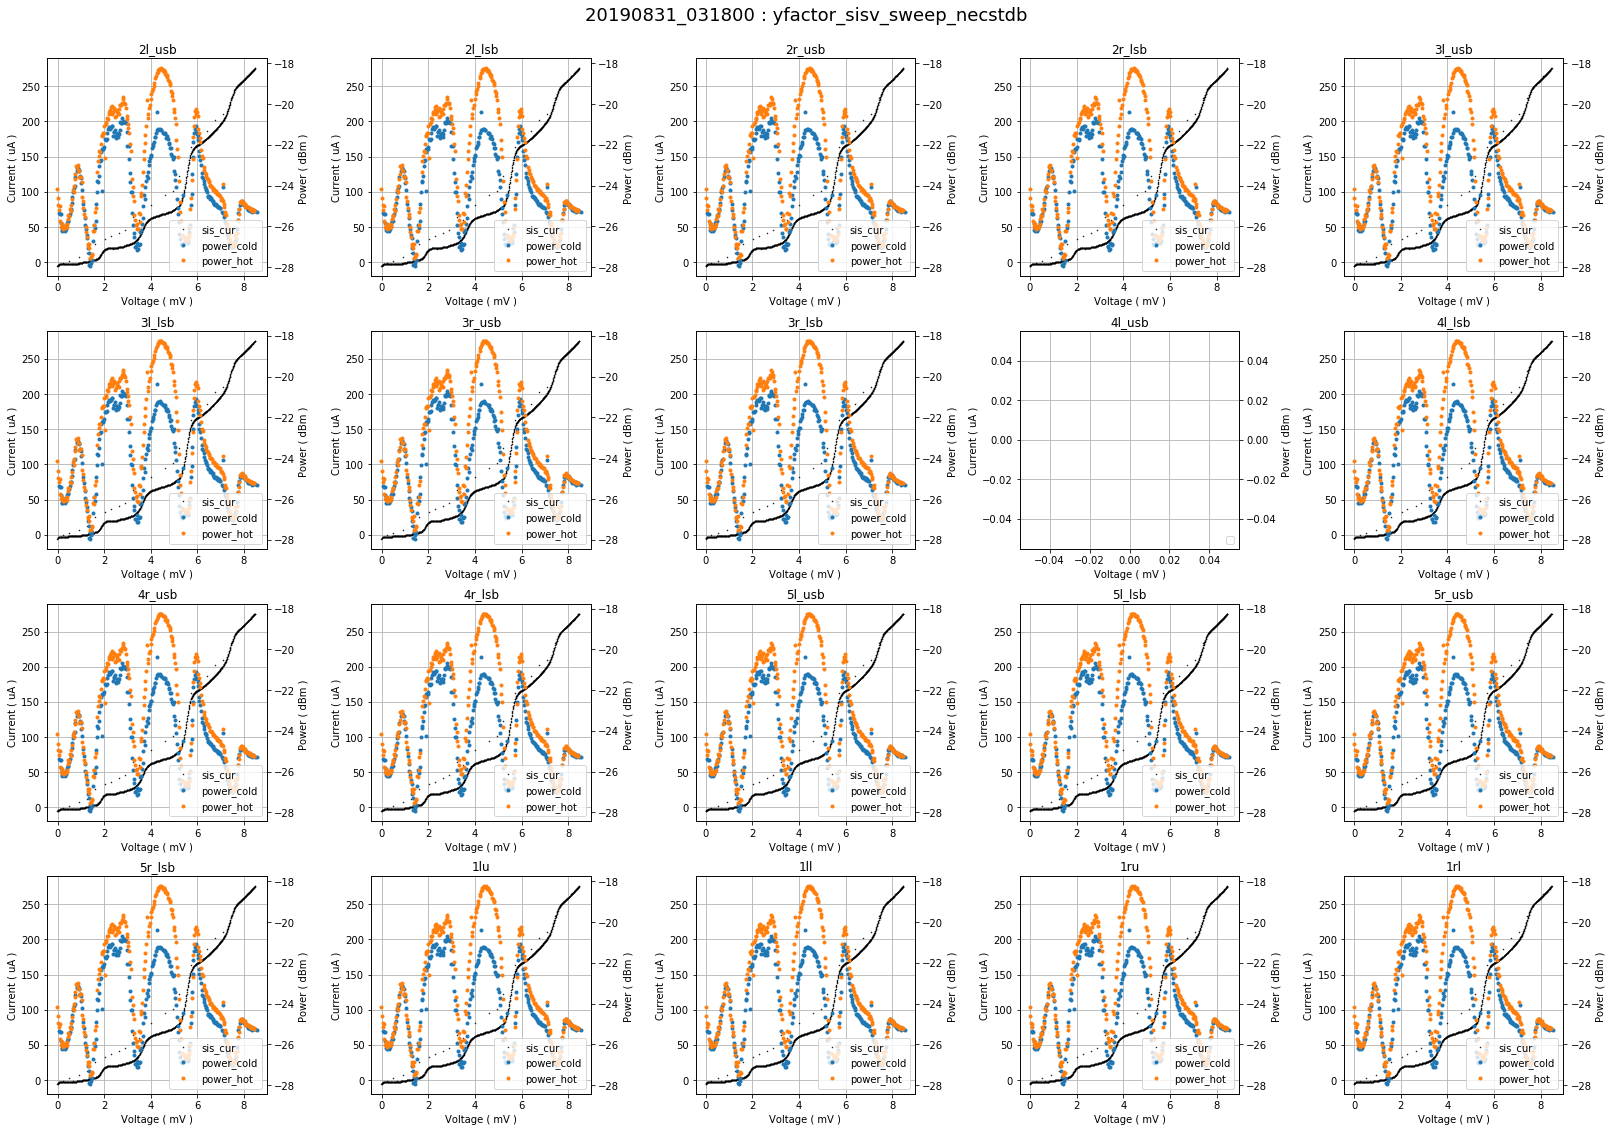

In [117]:
ncol = 5
nrow = 4
nax = ncol * nrow

figsize = (ncol * 4.5, nrow * 4)

fig = matplotlib.pyplot.figure(figsize=figsize)
ax = [fig.add_subplot(nrow, ncol, i+1) for i in range(nax)]

for _ax, key, data in zip(ax, dataset.keys(), dataset.values()):
    _ax_ = _ax.twinx()
    try:
        _ax.plot((data['sis_cur_{}_hot'.format(key)] + data['sis_cur_{}_hot'.format(key)]) / 2.,
                 '.', c='k', markersize=1, label='sis_cur')
    except:
        _ax.plot([])
    _ax.set_xlabel('Voltage ( mV )')
    _ax.set_ylabel('Current ( uA )')
    _ax.set_title(key)
    _ax.grid()

    try:
        _ax_.plot(data['if_{}_cold'.format(key)], '.', label='power_cold')
        _ax_.plot(data['if_{}_hot'.format(key)], '.', label='power_hot')
    except:
        _ax_.plot([])
    _ax_.set_ylabel('Power ( dBm ) ')

    h1, l1 = _ax.get_legend_handles_labels()
    h2, l2 = _ax_.get_legend_handles_labels()
    _ax_.legend(h1 + h2, l1 + l2, loc = 'lower right', fontsize=10)
#     _ax.legend()    
    
plt.suptitle('{date} : {mode}'.format(**locals()), fontsize=18)
plt.subplots_adjust(wspace=0.25, hspace=0.25, bottom=0.05)
plt.tight_layout()
plt.subplots_adjust(top=0.935)

plt.savefig('./hot_cold.png')
print('info : Saved image. ( hot_cold.png )')

### Y-factor を plot します。

info : Saved image. ( yfactor.png )


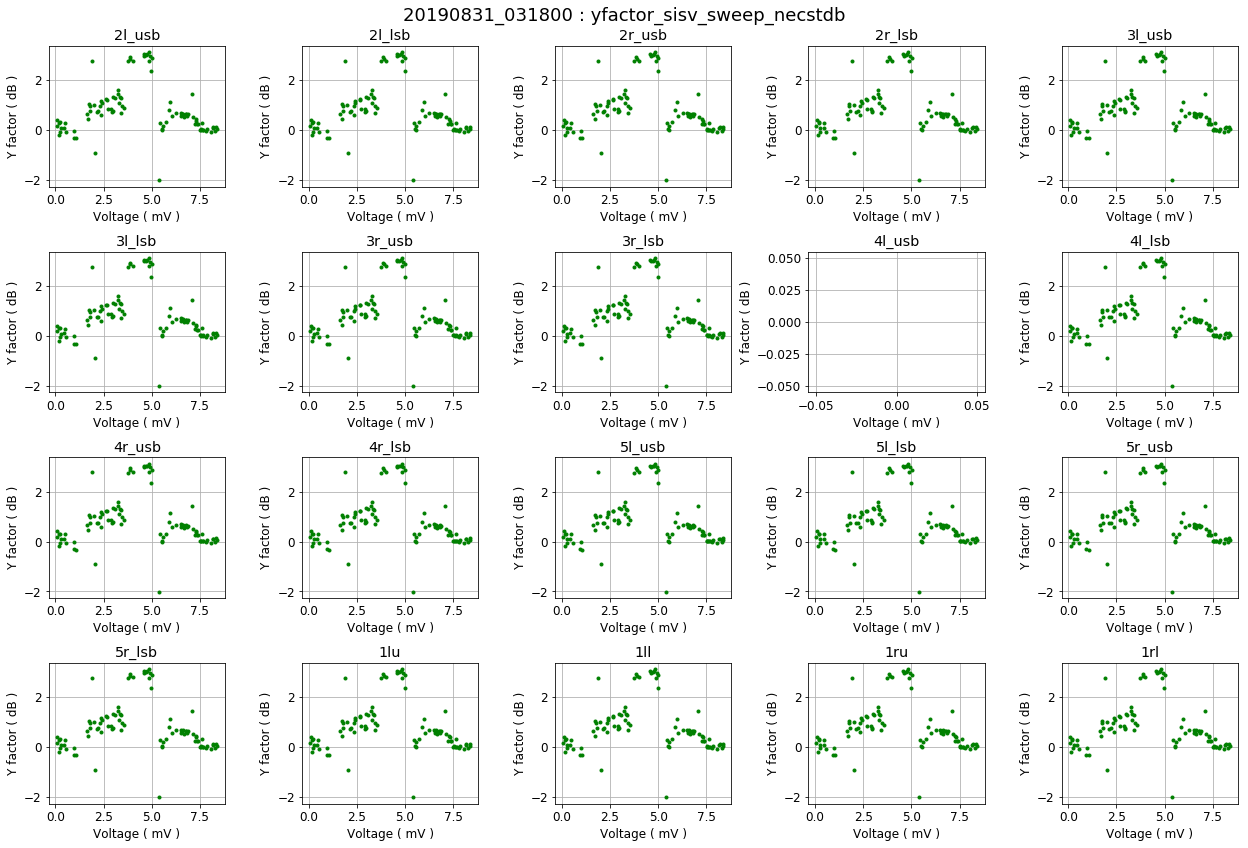

In [119]:
Tcold = 77.
Thot = 300.
figsize = (ncol * 3.5, nrow * 3)
fig = matplotlib.pyplot.figure(figsize=figsize)
matplotlib.rcParams['font.size'] = 12
ax = [fig.add_subplot(nrow, ncol, i+1) for i in range(nax)]

for _ax, key, data in zip(ax, dataset.keys(), dataset.values()):
    try:
        _Y = data['if_{}_hot'.format(key)] - data['if_{}_cold'.format(key)]
        _ax.plot(_Y, '.', c='g', label='Y factor')
    except:
        _ax.plot([])
    _ax.set_xlabel('Voltage ( mV )')
    _ax.set_ylabel('Y factor ( dB )')
    _ax.set_title(key)
    _ax.grid()
    
plt.suptitle('{date} : {mode}'.format(**locals()), fontsize=18)
plt.subplots_adjust(wspace=0.25, hspace=0.25, bottom=0.05)
plt.tight_layout()
plt.subplots_adjust(top=0.935)

plt.savefig('./yfactor.png')
print('info : Saved image. ( yfactor.png )')

### Trx を plot します。

info : Saved image. ( Trx.png )


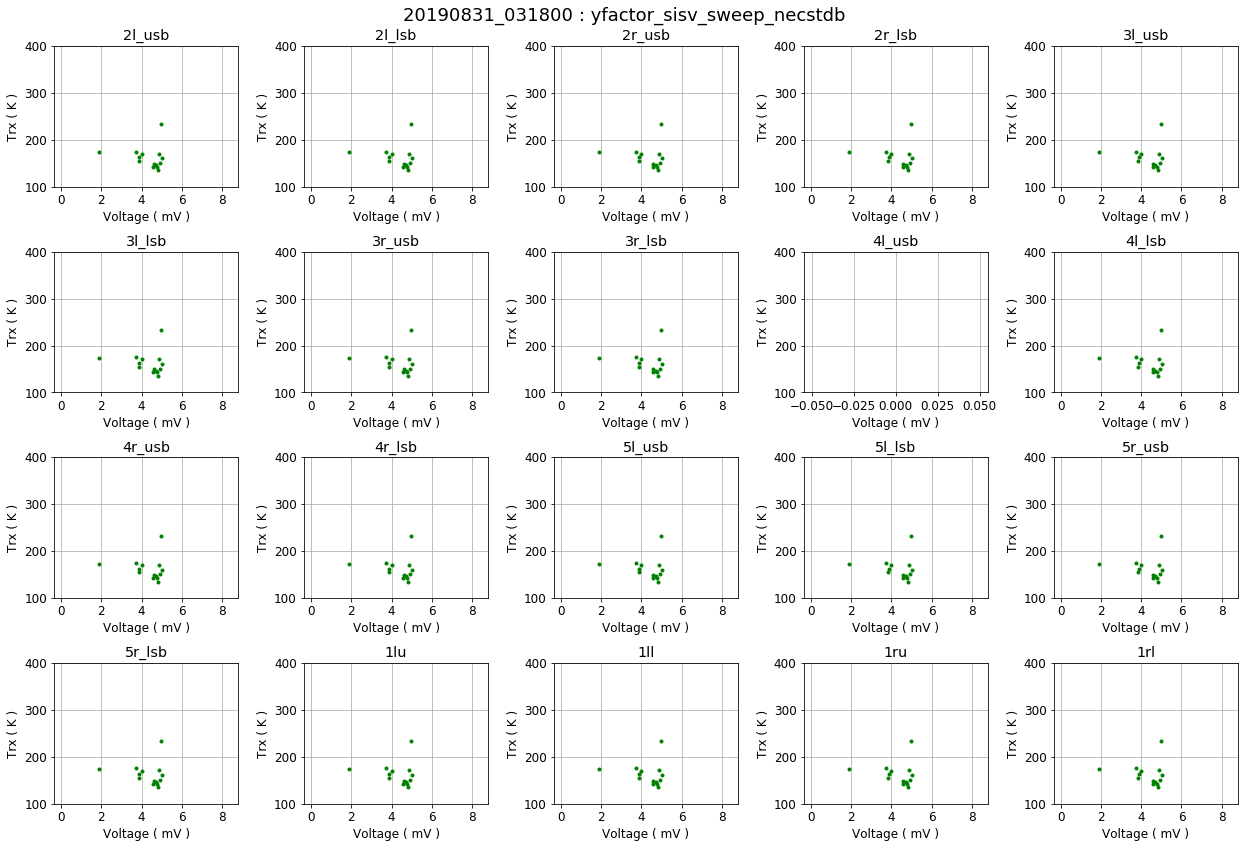

In [120]:
figsize = (ncol * 3.5, nrow * 3)
fig = matplotlib.pyplot.figure(figsize=figsize)
matplotlib.rcParams['font.size'] = 12
ax = [fig.add_subplot(nrow, ncol, i+1) for i in range(nax)]

for _ax, key, data in zip(ax, dataset.keys(), dataset.values()):
    try:
        _Y = 10 ** ((data['if_{}_hot'.format(key)] - data['if_{}_cold'.format(key)]) / 10.)
        _Trx = (Tcold * _Y - Thot) / (1 - _Y)
        _ax.plot(_Trx, '.', c='g', label='Trx')
    except:
        _ax.plot([])        
    _ax.set_xlabel('Voltage ( mV )')
    _ax.set_ylabel('Trx ( K )')
    _ax.set_title(key)
    _ax.grid()
    _ax.set_ylim(100., 400.)

plt.suptitle('{date} : {mode}'.format(**locals()), fontsize=18)
plt.subplots_adjust(wspace=0.25, hspace=0.25, bottom=0.05)
plt.tight_layout()
plt.subplots_adjust(top=0.935)

plt.savefig('./Trx.png')
print('info : Saved image. ( Trx.png )')